<h1><center>Escola Politénica da Universidade de São Paulo</h1></center> 
<br>

<img src="minerva.jpg">

<br>

<h1><center>PSI 3431 - Processamento Estatístico de Sinais</h1></center> 

<h1><center>Experiência 3: Densidade Espectral de Potência e Ruído de Quantização</h1></center>

<h1><center>Gabriel Moraes da Cruz NUSP: 10335020</h1></center> 

<h1><center>Thiago Souza Santos NUSP: 10335260</h1></center>



**Tarefas:**

Calcule a relação sinal/ruı́do (SNR), em dB.
Vamos usar o seguinte filtro para reduzir o efeito do ruı́do:

• Um filtro IIR H I (z) usando a aproximação elı́ptica. Você pode usar as
funções ellipord e ellip para o projeto (seu uso é semelhante ao das
funções usadas na Experiência 3).
Projete o filtro usando as especificações abaixo (escolha adequadamente ω p )

• Faixa de passagem: 0 ≤ ω ≤ ω p ,

• Faixa de rejeição: 0,2π rad/amostra = ω r ≤ ω ≤ π rad/amostra,

• Atenuação mı́nima na faixa de rejeição: 40 dB,

• Queda máxima na faixa de passagem δ p = 0,05.

In [35]:
using PyPlot, FixedPointNumbers, EllipsisNotation, SampledSignals, PyCall, DSP, Polynomials, Statistics;

In [36]:
sig = pyimport("scipy.signal");
matplotlib = pyimport("matplotlib.pyplot")
include("fxfilt.jl");
np = pyimport("numpy");

In [37]:
fo = 100π;
fa = 40e3;
Ta=1/fa;
n=0:Ta:3;
s = 0.5*cos.(2π*fo*n) + 0.3*cos.(4π*300*n) + 0.15*cos.(6π*fo*n);

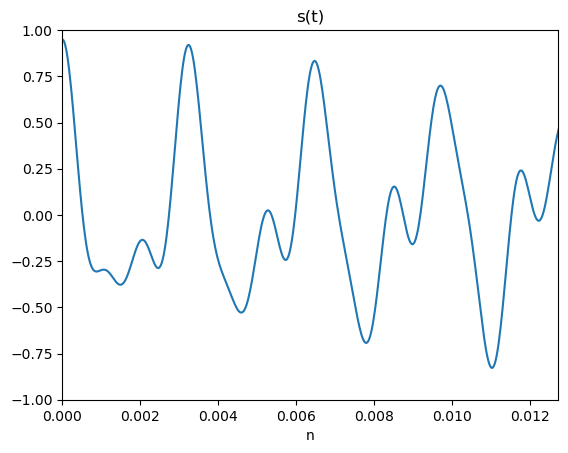

In [38]:
plot(n,s);
axis([0, 4/fo, -1, 1])
title("s(t)");
xlabel("n");

## Ítem 1 
Quantize os coeficientes  filtro, e calcule a resposta em frequência considerando os coeficientes quantizados. Compare com a resposta em frequência desejada (não é necessário refazer o projeto para atender às especificações).

In [39]:
sq = Fixed{Int16,4}.(s);

In [40]:
yq = SampleBuf(sq, fa)

120001-frame, 1-channel SampleBuf{Fixed{Int16,4}, 1}
3.000025s sampled at 40000.0Hz
▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇

In [41]:
ωp = 0.1π # TESTAR OUTROS VALORES
ωr = 0.2π
δp = 0.05
δr = 0.01;

## Funciomento do Filtro IIR com Aproximação Elíptica
O filtro visa minimizar o erro máximo nas duas bandas, ao contrário do filtro de Chebyshev, que apresenta ripple somente na banda passante. O módulo da resposta em frequência do filtro passa-baixas elíptico pode ser escrita como:

$$ G_{n} = | H_{n}(j\omega)| = \frac{1}{\sqrt{1+\epsilon^{2} R^{2}_{n}(\omega)}}$$

Sendo  $R^{2}_{n}(\omega)$  a função de Chebyshev de ordem n.

In [42]:
N, Wn = sig.ellipord(ωp/π, ωr/π, -20*log10(1-δp), -20*log10(δr)) 

(4, 0.1)

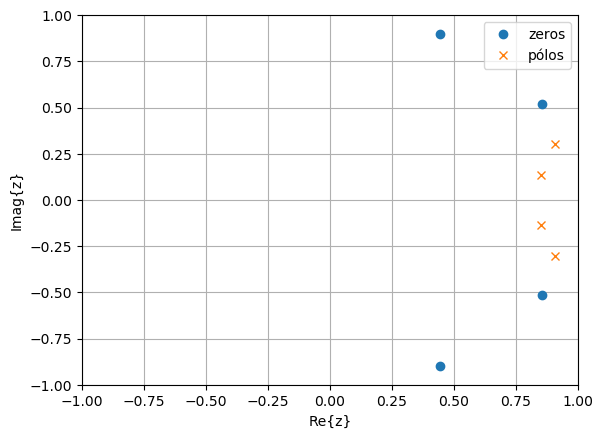

ganho= 0.012004547680162396

In [43]:
zpkellip = digitalfilter(Lowpass(Wn), Elliptic(N, -20*log10(1-δp),-20*log10(δr)))
print("ganho= ",zpkellip.k)
plot(real.(zpkellip.z),imag.(zpkellip.z),"o",label="zeros")
plot(real.(zpkellip.p),imag.(zpkellip.p),"x",label="pólos")
grid()
axis([-1,1,-1,1])
xlabel("Re{z}")
ylabel("Imag{z}")
legend();

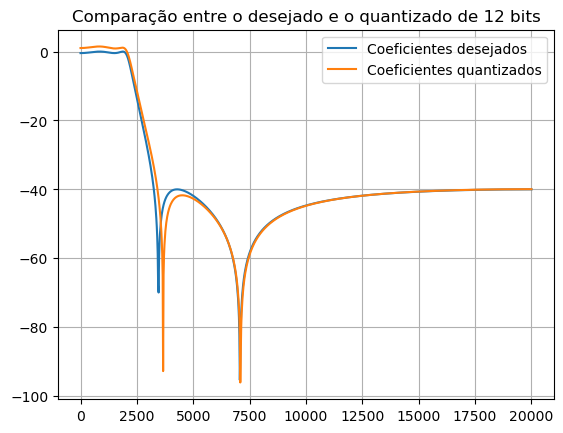

PyObject <matplotlib.legend.Legend object at 0x7fa7aeb9a760>

In [44]:
a = coefa(zpkellip);
b = coefb(zpkellip);
B_0 = 12
aq = Fixed{Int64,B_0-1}.(a)
bq = Fixed{Int64,B_0-1}.(b)
hq = PolynomialRatio(bq,aq);
ω=range(0,π,length=1000)
Hq=freqz(hq,ω);
H=freqz(zpkellip,ω);
plt.title("Comparação entre o desejado e o quantizado de 12 bits")
plot(ω*fa/(2π), amp2db.(abs.(H)),label="Coeficientes desejados")
plot(ω*fa/(2π), amp2db.(abs.(Hq)),label="Coeficientes quantizados")
grid()
legend()

## Ítem 2 

Seja $y_{Q}[n]$ a saída do filtro IIR. Considerando o filtro implementado com
precisão infinita, determine a funcao valor esperado $$m_{yQ}
[n] = E[{{y_{Q}}[n]]}$$


In [45]:
a = coefa(zpkellip);
b = coefb(zpkellip);
B0 = 5
sq = Fixed{Int16,B0-1}.(s)
yq = filt(b, a, sq);

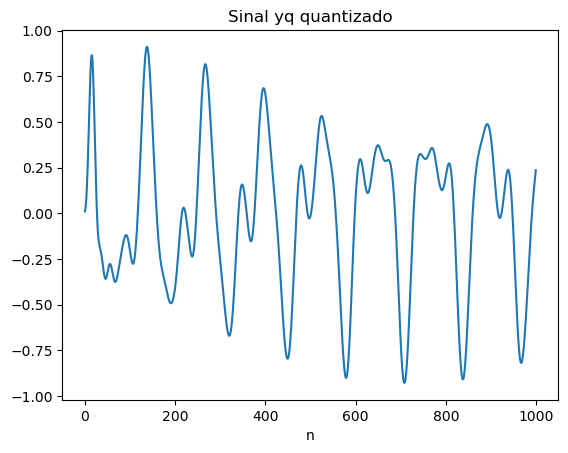

In [46]:
plot(yq[1:1000])
title("Sinal yq quantizado")
xlabel("n");

Foi visto em aula que o ruído de quantização pode ser tratado como ruído
aditivo, portanto modelado na forma:
$$𝛆_{in} ~ U(-2^{-B_{0}} ;2^{-B_{0}})$$
onde $B_{0}$ é o número de bits de quantização na
entrada.

Além disso, $𝛆_{Q}$ é iid, e portanto estacionário e ergódico, com isso, podemos
calcular a esperança:
$$m_{Y_{Q[n]}} = E{[Y_{q}[n]]} = E{Y[n]} + E[{𝛆_{Q}[n]}] $$
como $$𝛆_{Q}[n]$$ é um ruído branco, que implica: $$E{{𝛆_{Q}[n]}} = 0$$

$$E{y[n]} = y[n]$$ portanto:
$$m_{y_{Q[n]}} = E{y_{Q}[n]} = y[n]$$


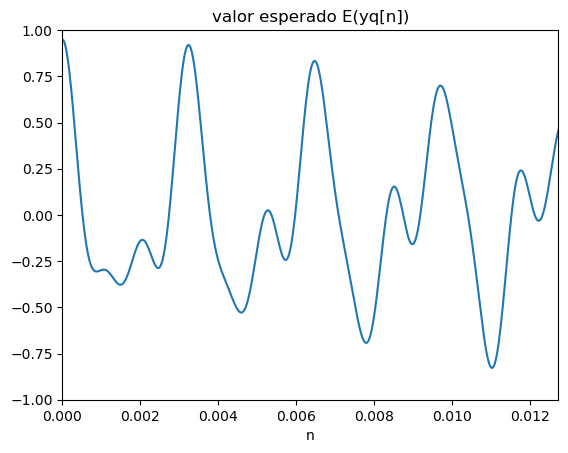

In [47]:
myq = s;
plot(n,s);
axis([0, 4/fo, -1, 1])
title("valor esperado E(yq[n])");
xlabel("n");

## Ítem 3

Seja y[n] a resposta do filtro com a entrada limpa (sem quantização). Defina $ε_{Q}[n] = y_{Q}[n] − y[n]$. Esse sinal pode ser considerado um processo estacionário? Qual é o valor DC e a potência média de $ε_{Q}[n]$? Calcule a SNR na saı́da. Você pode usar a função impz para calcular a resposta ao impulso do filtro IIR.

In [48]:
y = filt(b,a,s);

In [49]:
ϵ = yq - y;

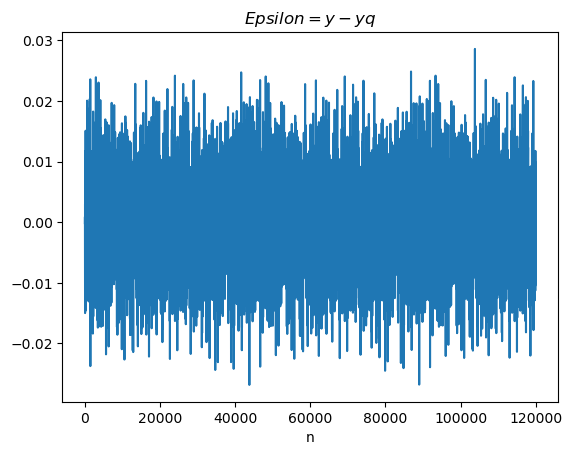

In [50]:
plot(ϵ)
title(L"Epsilon = y - yq")
xlabel("n");

### Verificando se o processo é estacionário

Para um processor ser estacionário no sentido amplo(WSS) é necessário que as propriedades estatísticas não variem ao longo do tempo

Pode-se notar abaixo que os valores da média e do desvio padrão nos intervalos não variam de maneira significativa. Dessa forma podemos afirmar  que $\epsilon_{Q}[n]$ é estacionário no sentido amplo.

In [51]:
processo1 = ϵ[1:10000]
processo2 = ϵ[10000:20000]
processo3 = ϵ[20000:30000]
processo4 = ϵ[30000:40000]
processo5 = ϵ[40000:50000]
processo6 = ϵ[50000:60000]
processo7 = ϵ[60000:70000]
processo8 = ϵ[70000:80000]

print("\nProcesso_1: ", mean(processo1))
print("\nProcesso_2: ", mean(processo2))
print("\nProcesso_3: ", mean(processo3))
print("\nProcesso_4: ", mean(processo4))
print("\nProcesso_5: ", mean(processo5))
print("\nProcesso_6: ", mean(processo6))
print("\nProcesso_7: ", mean(processo7))
print("\nProcesso_8: ", mean(processo8))
print("\nDesvio Processo_1: ", std(processo1))
print("\nDesvio Processo_2: ", std(processo2))
print("\nDesvio Processo_3: ", std(processo3))
print("\nDesvio Processo_4: ", std(processo4))
print("\nDesvio Processo_5: ", std(processo5))
print("\nDesvio Processo_6: ", std(processo6))
print("\nDesvio Processo_7: ", std(processo7))
print("\nDesvio Processo_8: ", std(processo8))



Processo_1: 2.4718565557662452e-5
Processo_2: -8.33804355753892e-5
Processo_3: -0.00013377379812499885
Processo_4: -0.00017834184875653998
Processo_5: 0.0002535212335846277
Processo_6: -0.0002185727207741555
Processo_7: -3.7075999228325916e-5
Processo_8: -0.00012011344210267812
Desvio Processo_1: 0.005837480033914945
Desvio Processo_2: 0.0059704289702422475
Desvio Processo_3: 0.005927074326152235
Desvio Processo_4: 0.005780891577664442
Desvio Processo_5: 0.006056273632006611
Desvio Processo_6: 0.0057524514219068346
Desvio Processo_7: 0.005954124452886959
Desvio Processo_8: 0.005979719270308382

## Cálculando o valor DC

No item anterior foi visto que $𝛆_{in}$ é estacionário e ergódico e o sistema é linear,
a partir disso podemos afirmar que $𝛆_{Q}$ também é.
$$Valor_{DC} = E(\epsilon_{Q}[n]) $$


In [52]:
print("valor dc: ", mean(ϵ))

valor dc: -5.08837813577861e-5

## Cálculo da Potência Média do Ruído

Podemos achar a Potência Média do Ruído usando o Teorema de Parseval, da seguinte forma: 
$$ P_{\epsilon} =  {\sigma_{0}}^2 \sum_{n=0}^{00} h^2 [n]$$

In [53]:
σ20 = (2.0^(-2B0))/3
pR=σ20*sum(impz(zpkellip,500).^2)
print("\npotência do ruido teórica: ", pR)


potência do ruido teórica: 3.390854202126129e-5

##  Cálculo da Relação Sinal/Ruído SNR

Fórmula para calcular a potência do sinal:
$$P_{s} = \sum_{n=0}^{N} \frac{A_{n}²}{2}$$

A potência do sinal de saída e de entrada podem ser consideradas iguais, assumindo que o ganho do filtro na banda passante é constante igual a 1.

Desta forma, a relação SNR pode ser descrita como:

$$ SNR = \frac {Pot_{s}} {Pot_{\epsilon}} $$


In [54]:
pS = (0.5^2) + (0.3^2) + (0.15^2)

SNR = pow2db(pS/pR)

print("\nsnr: ",SNR, " dB")


snr: 40.28998894255838 dB

## Ítem 4
Use a função filter (Matlab) ou filt (Julia) para calcular a saída
$y_{Q[n]}$ para uma realização do filtro, usando como entrada o sinal quantizado $s_{q}[n]$. Use o conceito de ergodicidade para calcular a potência
média do ruído na saída do filtro, e compare com o valor teórico do
item anterior (você pode considerar o ruído de quantização como sendo um processo ergódico).

In [55]:
yq = filt(b, a, sq);
y = filt(b,a,s);
ϵ = yq - y;

In [56]:
print("\npotencia do ruido teórico: ", pR)
print("\npotencia do ruido experimental com ergodicidade: ", var(ϵ))


potencia do ruido teórico: 3.390854202126129e-5
potencia do ruido experimental com ergodicidade: 3.485346985541121e-5

## Ítem 5
Use agora a função filterfx.m (Matlab) ou fxfilt (Julia) para gerar os sinais de saída considerando que o filtro seja implementado
usando aritm´etica de precisão finita com 12 bits para as contas (Use Fixed{Int16,11} em Julia, para evitar overflow). Considere que cálculos intermediários possam usar um registrador de precisão dupla.

In [57]:
B_filtro = 12
a_q = Fixed{Int16,B_filtro-1}.(a);
b_q = Fixed{Int16,B_filtro-1}.(b);

In [58]:
h_q = PolynomialRatio(b_q, a_q);
H_q = freqz(h_q,ω);

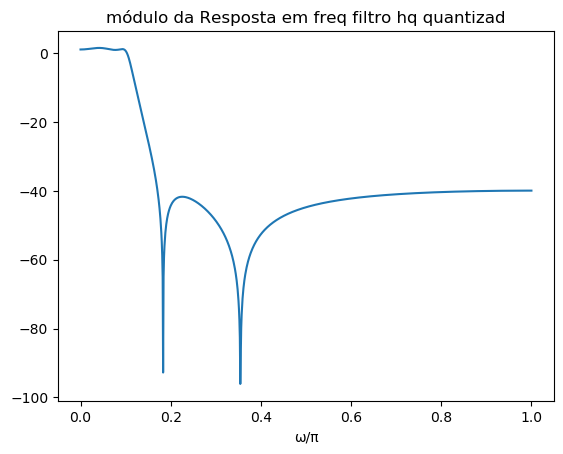

In [59]:
title("módulo da Resposta em freq filtro hq quantizad");
plot(ω/π, amp2db.(abs.(H_q)));
xlabel("ω/π");

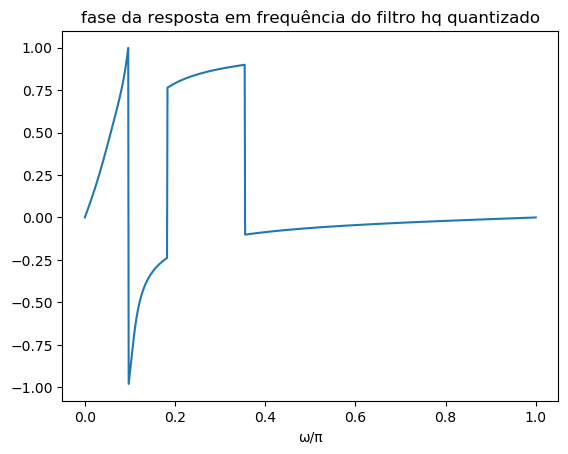

In [60]:
title("fase da resposta em frequência do filtro hq quantizado");
plot(ω/π, angle.(H_q)/π);
xlabel("ω/π");

## Obtendo saídas do filtro quantizado

Utilizando a função fxfilter para gerar os sinais de saída, considerando o filtro implementado em aritmética de precisão finita.
Faremos para dois casos: o sinal s quantizado $(s_{q})$ e o sinal s puro.

In [61]:
y_quant_q = fxfilt(b_q, a_q, Fixed{Int16,B_filtro-1}.(sq), true); #precdupla=True
y_quant = fxfilt(b_q, a_q, Fixed{Int16,B_filtro-1}.(s), true); #precdupla=True

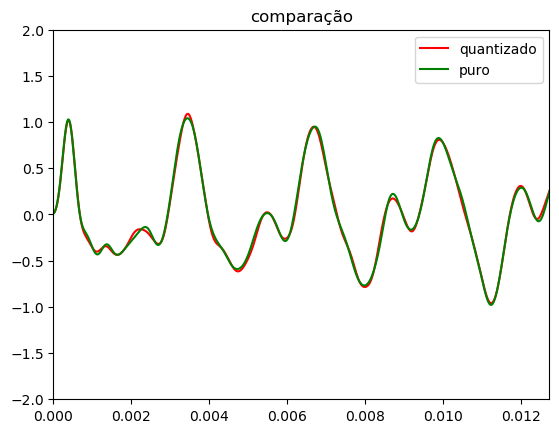

In [62]:
title("comparação");
plot(n, y_quant_q, "r", label="quantizado");
plot(n, y_quant, "g", label="puro");
axis([0,4/fo,-2,2]);
legend();

## Ítem  6
Novamente, calcule o sinal $ε_{T}[n]$ para este exemplo, use ergodicidade para calcular a potência média, e calcule a SNR de saı́da.

In [63]:
ϵT = y_quant_q - y_quant;

In [64]:
print("potência experimental do ruído: ", var(ϵT))

potência experimental do ruído: 0.0008063756829685584

## Relação Sinal/Ruído

In [65]:
SNR = pow2db(pS/var(ϵT))
print("relação snr experimental calculada: ", SNR, " dB")

relação snr experimental calculada: 26.527705881743678 dB

## Ítem 7
Para o caso do filtro implementado usando 12 bits do item anterior, calcule teoricamente a potência média do ruı́do total na saı́da do filtro. Leia a função filterfx.m (ou fxfilt) e considere exatamente como as contas são feitas. Compare o resultado teórico com o do item anterior.
<br>
<img src="img3.jpeg">
<br>
<img src="img4.jpeg">
<br>

In [66]:
h2_q = PolynomialRatio([1], a_q);
h1_q = PolynomialRatio(b_q, a_q);

## Cálculando SNR teórico 

Dada a fórmula da potência do ruído na saída obtida acima, temos que:

In [67]:
potRuido_teorica = ((2.0^(-2*B0)/3.0)*(sum(impz(h1_q, 500).^2))) + ((2.0^(-2*B_filtro)/3.0)*(sum(impz(h2_q, 500).^2)))
SNR = pow2db(pS/potRuido_teorica)
print("relação snr teórica calculada: ", SNR, " dB")

relação snr teórica calculada: 31.244491112731527 dB

## Ítem 8
Qual seria o resultado para o filtro IIR se fosse usada a forma direta canônica vista em aula? (ou seja, aquela em que a parte com realimentação é feita antes da parte FIR, veja a apostila) Não é preciso implementar o filtro, apenas calcular o valor teórico da SNR.
<br>
<img src="img1.jpeg">
<br>
A potência teórica na forma canônica a partir da dedução simplificada abaixo:
<br>
<img src="img2.jpeg">
<br>

In [68]:
potRuido_teo_can = (((2.0^(-2B_filtro)+2.0^(-2*B0))/3.0)*sum(impz(h1_q,500).^2))+((2.0^(-2*B_filtro))/3.0);

SNR = pow2db(pS/potRuido_teo_can)
print("relação snr teórica na forma canônica calculada: ", SNR, " dB")

relação snr teórica na forma canônica calculada: 38.89584431491968 dB